In [1]:
import math
import functools
from typing import Dict, Tuple

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import jax 
import jax.numpy as jnp
from typing import Dict

from qdax.core.map_elites import MAPElites
from qdax.core.containers.mapelites_repertoire import compute_euclidean_centroids, MapElitesRepertoire

from qdax import environments
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.tasks.brax_envs import (
    scoring_function_brax_envs,
    reset_based_scoring_function_brax_envs,
    make_policy_network_play_step_fn_brax
)
from qdax.custom_types import EnvState, Params, RNGKey
from qdax.core.containers.mapelites_repertoire import (
    MapElitesRepertoire,
    compute_cvt_centroids,
)

from qdax_es.core.custom_repertoire_mapelites import CustomMAPElites
from qdax_es.core.containers.gp_repertoire import GPRepertoire
from qdax_es.core.containers.mae_repertoire import MAERepertoire

from qdax_es.utils.count_plots import plot_archive_value

I0000 00:00:1718292015.995121 2256075 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
from jax.config import config
# config.update("jax_debug_nans", True)

In [3]:
es_pop = 32
pool_size = 4 #@param {type:"integer"}

batch_size = es_pop * pool_size #@param {type:"integer"}
print("batch_size", batch_size)
initial_batch = batch_size
env_name = "pointmaze"
episode_length = 100
num_iterations = 1000
seed = 42
policy_hidden_layer_sizes = (64, 64)
num_init_cvt_samples = 1000
num_centroids = 1000
min_bd = -1.0
max_bd = 1.0
emitter_type = "imp" #@param["opt", "imp", "rnd"]
sigma_g = .1

es_type = "Sep_CMA_ES"

from evosax import Strategies
assert es_type in Strategies, f"{es_type} is not one of {Strategies.keys()}"

batch_size 128


In [ ]:
es_params = {
    "sigma_init": 0.1,
    "popsize": 32,
}

setup_config = {
    "env": "pointmaze",
    "es_type": "Sep_CMA_ES",
    "pool_size": 4,
    "episode_length": 100,
    "num_iterations": 1000,
    "seed": 42,
    "policy_hidden_layer_sizes": (64, 64),
    "num_init_cvt_samples": 1000,
    "num_centroids": 1000,
    "emitter_type": "imp",
    "sigma_g": .1,
}

In [ ]:
random_key = jax.random.PRNGKey(seed)

(
    env,
    policy_network,
    scoring_fn,
    reward_offset
) = create_taks(
    config, 
    random_key=random_key,
)

## Defines the scoring function

In [23]:
from qdax_es.utils.setup import create_task

In [4]:
# Init environment
env = environments.create(env_name, episode_length=episode_length)

# Init a random key
random_key = jax.random.PRNGKey(seed)

# Init policy network
policy_layer_sizes = policy_hidden_layer_sizes + (env.action_size,)
policy_network = MLP(
    layer_sizes=policy_layer_sizes,
    kernel_init=jax.nn.initializers.lecun_uniform(),
    final_activation=jnp.tanh,
)

In [5]:
# Init population of controllers
random_key, subkey = jax.random.split(random_key)
keys = jax.random.split(subkey, num=initial_batch)
fake_batch = jnp.zeros(shape=(initial_batch, env.observation_size))
init_variables = jax.vmap(policy_network.init)(keys, fake_batch)

# Play reset fn
# WARNING: use "env.reset" for stochastic environment,
# use "lambda random_key: init_state" for deterministic environment
play_reset_fn = env.reset

# Prepare the scoring function
bd_extraction_fn = environments.behavior_descriptor_extractor[env_name]
scoring_fn = functools.partial(
    reset_based_scoring_function_brax_envs,
    episode_length=episode_length,
    play_reset_fn=play_reset_fn,
    play_step_fn=make_policy_network_play_step_fn_brax(env, policy_network),
    behavior_descriptor_extractor=bd_extraction_fn,
)

In [6]:

# Get minimum reward value to make sure qd_score are positive
reward_offset = environments.reward_offset[env_name]

# Define a metrics function
def metrics_fn(repertoire: MapElitesRepertoire) -> Dict:

    # Get metrics
    grid_empty = repertoire.fitnesses == -jnp.inf
    qd_score = jnp.sum(repertoire.fitnesses, where=~grid_empty)
    # Add offset for positive qd_score
    qd_score += reward_offset * episode_length * jnp.sum(1.0 - grid_empty)
    coverage = 100 * jnp.mean(1.0 - grid_empty)
    max_fitness = jnp.max(repertoire.fitnesses)

    return {"qd_score": qd_score, "max_fitness": max_fitness, "coverage": coverage}

# Compute the centroids
centroids, random_key = compute_cvt_centroids(
    num_descriptors=env.behavior_descriptor_length,
    num_init_cvt_samples=num_init_cvt_samples,
    num_centroids=num_centroids,
    minval=min_bd,
    maxval=max_bd,
    random_key=random_key,
)


In [7]:
def net_shape(net):
    return jax.tree_map(lambda x: x.shape, net)


## Emitter

In [8]:
es_params = {
    "sigma_init": sigma_g,
    "popsize": int(batch_size / pool_size),
}

In [9]:
import importlib

jedi_mod = importlib.import_module("qdax_es.core.emitters.jedi_emitter")
jedi_mod = importlib.reload(jedi_mod)

jedi_pool_mod = importlib.import_module("qdax_es.core.emitters.jedi_pool_emitter")
jedi_pool_mod = importlib.reload(jedi_pool_mod)

JEDiEmitter = jedi_mod.JEDiEmitter
UniformJEDiPoolEmitter = jedi_pool_mod.UniformJEDiPoolEmitter
GPJEDiPoolEmitter = jedi_pool_mod.GPJEDiPoolEmitter

from qdax_es.utils.restart import FixedGens, ConvergenceRestarter

# restarter = FixedGens(10)
restarter = ConvergenceRestarter(
    min_score_spread=0.2,
    min_gens=3,
    # max_gens=100
    )
wtfs_alpha = 0.3

emitter = JEDiEmitter(
    centroids=centroids,
    es_hp=es_params,
    es_type=es_type,
    wtfs_alpha = wtfs_alpha,
    restarter=restarter,
)

In [10]:
emitter = GPJEDiPoolEmitter(
    pool_size=pool_size,
    emitter=emitter
)

In [11]:
repertoire_type = GPRepertoire
# repertoire_type = MAERepertoire

map_elites = CustomMAPElites(
    scoring_function=scoring_fn,
    emitter=emitter,
    metrics_function=metrics_fn,
    repertoire_type=repertoire_type,
)

In [12]:
if repertoire_type == GPRepertoire:
    repertoire_kwargs = {
        "n_steps": 100,
        "weighted": True,
    }
elif repertoire_type == MAERepertoire:
    repertoire_kwargs = {
        "min_threshold" : -100,
        "archive_learning_rate" : 0.1,
    }


with jax.disable_jit():
    repertoire, emitter_state, random_key = map_elites.init(
        init_variables, 
        centroids, 
        random_key,
        repertoire_kwargs=repertoire_kwargs
    )

/home/paul/QDax_ES/qdax_es/core/containers/gp_repertoire.py:40: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = super().init(


Using ANNReshaper
Genotype dim: 4482
need_restart: 0


In [13]:
# with jax.disable_jit():
# map_elites.update(repertoire, emitter_state, random_key);

In [14]:
%%time

(repertoire, emitter_state, random_key,), metrics = jax.lax.scan(
    map_elites.scan_update,
    (repertoire, emitter_state, random_key),
    (),
    length=num_iterations,
)

need_restart: 0
need_restart: 0
need_restart: 0
need_restart: 0
need_restart: 0
need_restart: 1
need_restart: 2
need_restart: 0
need_restart: 1
need_restart: 0
need_restart: 1
need_restart: 0
need_restart: 0
need_restart: 0
need_restart: 2
need_restart: 2
need_restart: 0
need_restart: 0
need_restart: 0
need_restart: 1
need_restart: 1
need_restart: 2
need_restart: 0
need_restart: 0
need_restart: 1
need_restart: 0
need_restart: 0
need_restart: 2
need_restart: 0
need_restart: 0
need_restart: 1
need_restart: 0
need_restart: 1
need_restart: 1
need_restart: 0
need_restart: 0
need_restart: 1
need_restart: 0
need_restart: 1
need_restart: 0
need_restart: 1
need_restart: 0
need_restart: 1
need_restart: 1
need_restart: 0
need_restart: 0
need_restart: 1
need_restart: 1
need_restart: 0
need_restart: 0
need_restart: 2
need_restart: 0
need_restart: 0
need_restart: 0
need_restart: 1
need_restart: 3
need_restart: 1
need_restart: 0
need_restart: 0
need_restart: 0
need_restart: 1
need_restart: 1
need_res

In [15]:
for k, v in metrics.items():
    print(f"{k} after {num_iterations * batch_size}: {v[-1]}")

coverage after 128000: 89.20000457763672
max_fitness after 128000: -27.783723831176758
qd_score after 128000: 114265.1328125


In [16]:
repertoire.total_count

Array(128128., dtype=float32)

In [17]:
emitter_state.emitter_states.restart_state

RestartState(generations=Array([1001, 1001, 1001, 1001], dtype=int32, weak_type=True))

## Plot results

Save figure in:  ./plots/pointmaze/Sep_CMA_ES_JEDi_imp.png


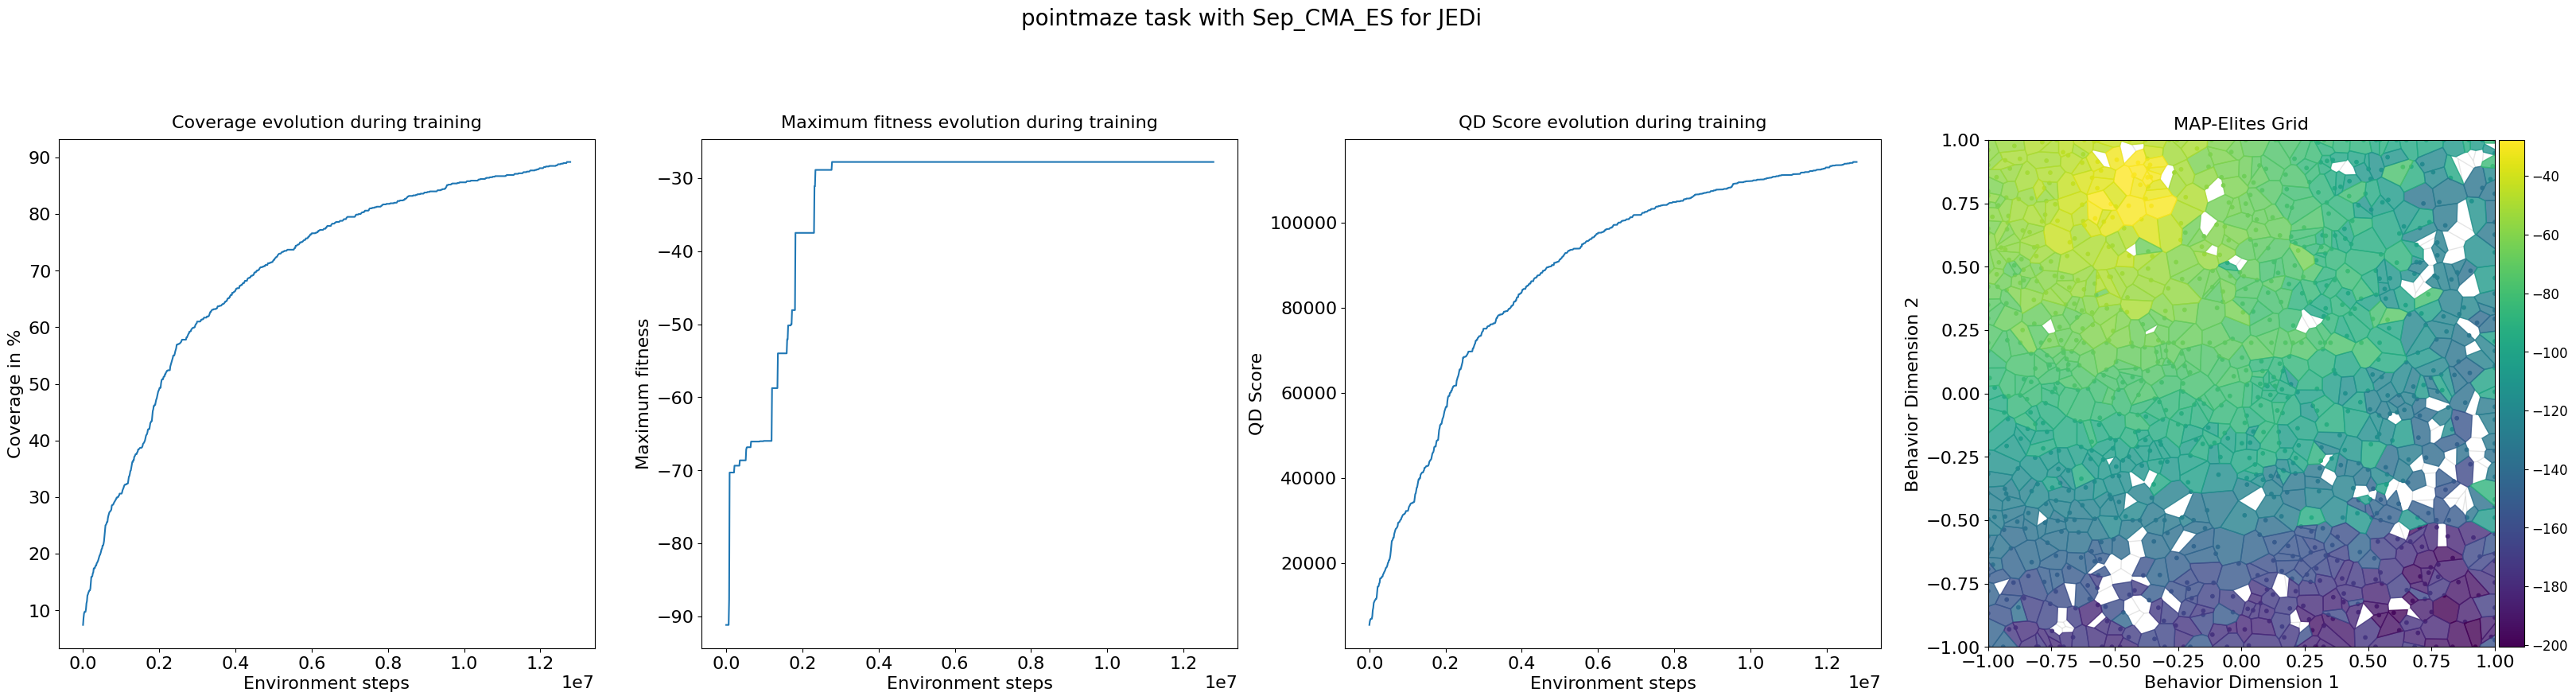

In [20]:
env_steps = jnp.arange(num_iterations) * emitter.batch_size * episode_length

from qdax.utils.plotting import plot_map_elites_results
import matplotlib

%matplotlib inline
fig, axes = plot_map_elites_results(
    env_steps=env_steps,
    metrics=metrics,
    repertoire=repertoire,
    min_bd=min_bd,
    max_bd=max_bd,
)

# main title
plt.suptitle(f"{env_name} task with {es_type} for JEDi", fontsize=20)

# udpate this variable to save your results locally
savefig = True
if savefig:
    figname = f"./plots/{env_name}/{es_type}_JEDi_"  + emitter_type + ".png"
    # create folder if it does not exist
    import os
    os.makedirs(os.path.dirname(figname), exist_ok=True)
    print("Save figure in: ", figname)
    plt.savefig(figname)

Save figure in:  ./plots/pointmaze/Sep_CMA_ES_JEDi_0.3_count.png


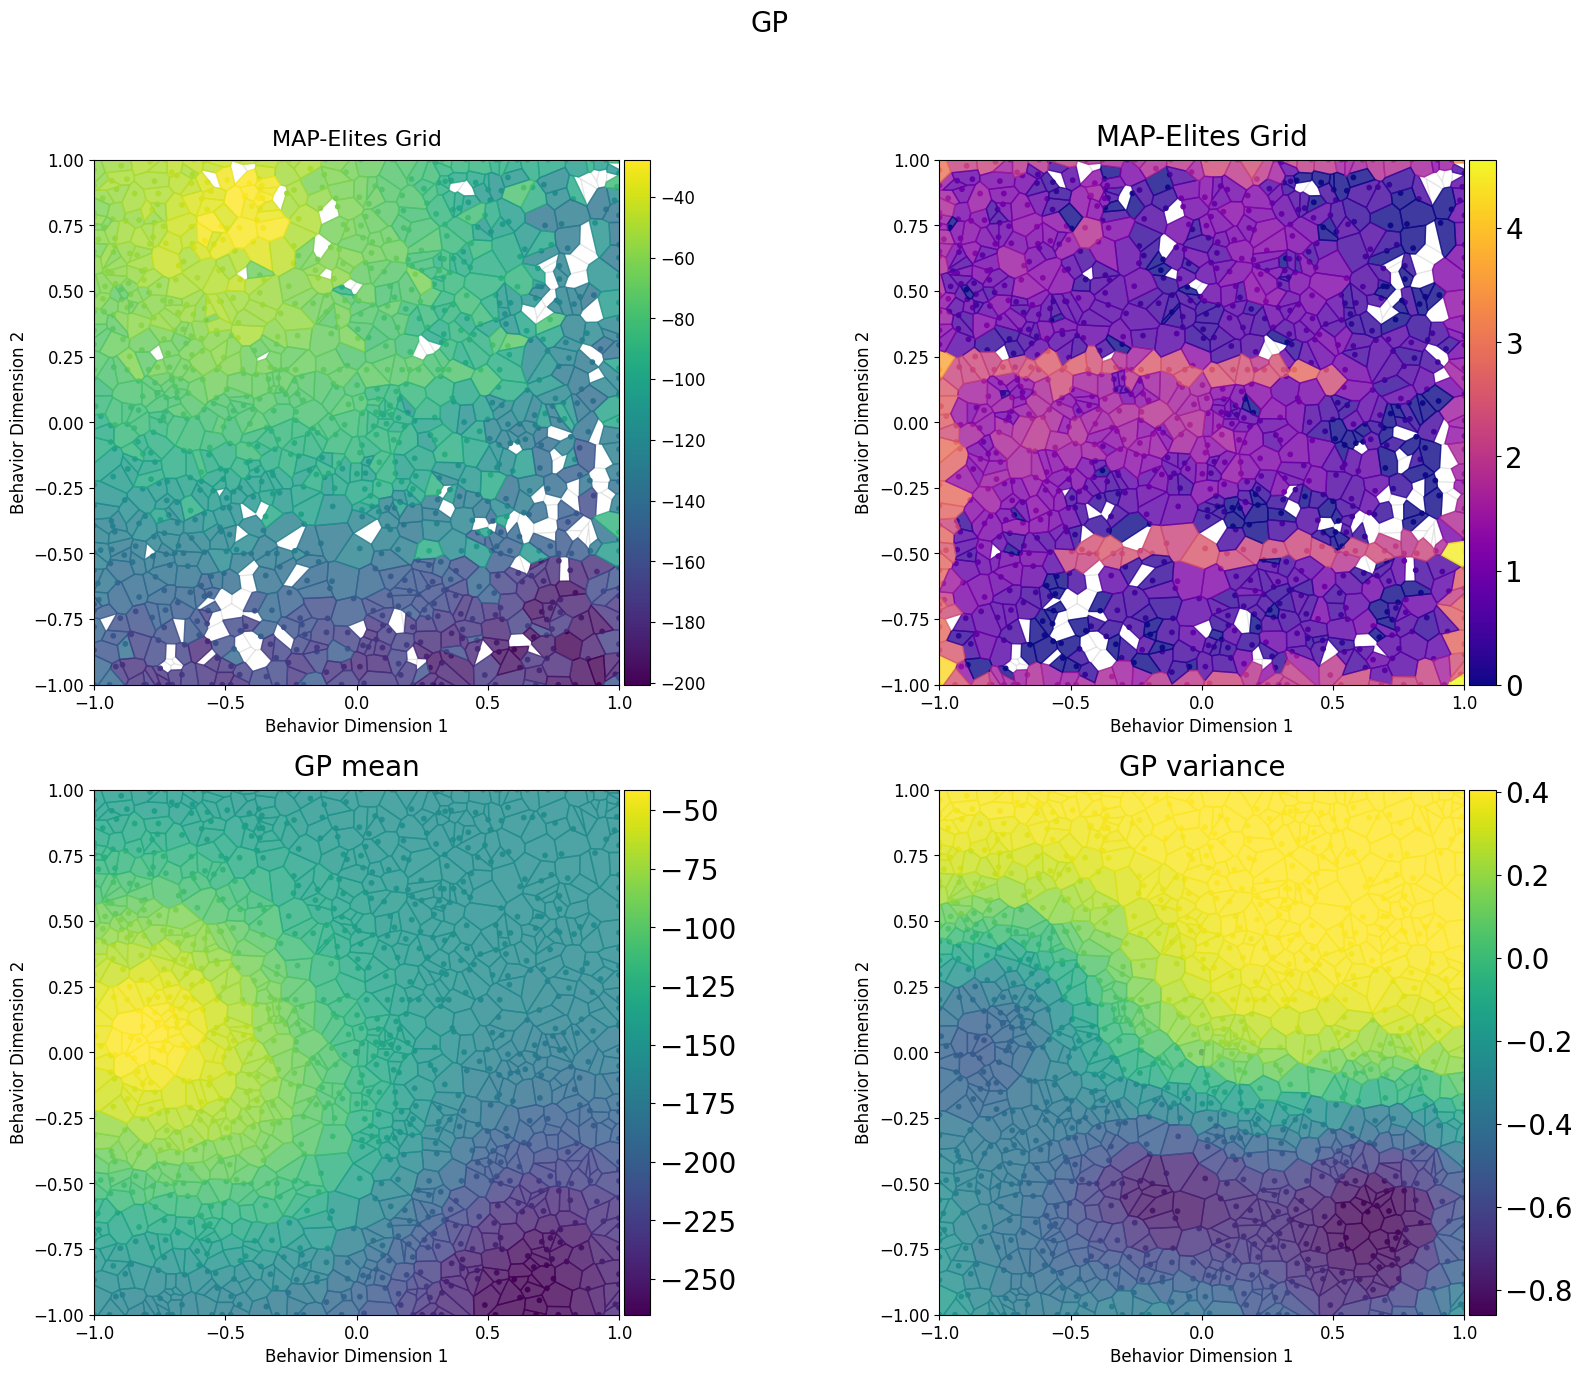

In [19]:
final_repertoire = repertoire.fit_gp(10)
fig, axes = final_repertoire.plot(-1, 1);

if savefig:
    figname = f"./plots/{env_name}/{es_type}_JEDi_"  + str(wtfs_alpha) + "_count.png"
    # create folder if it does not exist
    import os
    os.makedirs(os.path.dirname(figname), exist_ok=True)
    print("Save figure in: ", figname)
    plt.savefig(figname)